<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import sys
sys.path.append('../../')

import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from tslearn.datasets import UCR_UEA_datasets
from sklearn import svm
import signature_features
from signature_features import *
import utils
from utils import *
import experiments
from experiments import * 
from sklearn.metrics import accuracy_score
# import gpflow
from sklearn.preprocessing import LabelEncoder
from scipy.io import arff

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

In [6]:
data_train = arff.loadarff('Multivariate_arff/Epilepsy/Epilepsy_TRAIN.arff')
data_test = arff.loadarff('Multivariate_arff/Epilepsy/Epilepsy_TEST.arff')

df_train = pd.DataFrame(data_train[0])
df_test = pd.DataFrame(data_test[0])

labels_train = df_train.iloc[:,1]
labels_test = df_test.iloc[:,1]

y_train = LabelEncoder().fit_transform(labels_train)
y_test = LabelEncoder().fit_transform(labels_test)

x_train = [np.array(a.tolist()).T for a in df_train.iloc[:,0]]
x_test = [np.array(a.tolist()).T for a in df_test.iloc[:,0]]

In [7]:
df_train.head()

,relationalAtt,activity
0,"[[0.35, 0.4, 0.44, 0.47, 0.48, 0.47, 0.44, 0.4...",b'EPILEPSY'
1,"[[-0.91, -0.92, -0.95, -0.95, -0.95, -0.94, -0...",b'EPILEPSY'
2,"[[0.32, 0.71, 0.7, 0.75, 0.88, 0.58, 1.34, 0.6...",b'EPILEPSY'
3,"[[-0.68, -0.36, -0.13, -0.38, -0.49, -0.48, -0...",b'EPILEPSY'
4,"[[0.34, 0.53, 0.58, 0.61, 0.64, 0.63, 0.44, 0....",b'EPILEPSY'


In [8]:
df_train.iloc[:,1].unique()

array([b'EPILEPSY', b'WALKING', b'RUNNING', b'SAWING'], dtype=object)

In [9]:
def transform(paths, scale=1.):
    return [scale*p for p in paths]

In [10]:
x_train = np.array(transform(x_train))
x_test = np.array(transform(x_test))
l = x_train.shape[1]

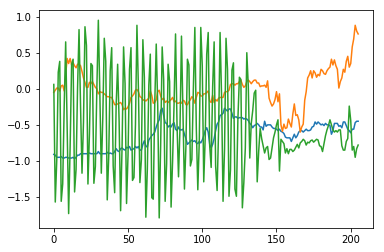

In [11]:
plt.plot(x_train[1])
plt.show()

In [12]:
x_train.shape

(137, 206, 3)

In [13]:
x_test.shape

(138, 206, 3)

In [417]:
X_aug_train =  np.concatenate([np.concatenate(np.array_split(e[None,:-6,:],10,axis=1))[None,:,:,:] for e in x_train])
X_aug_test =  np.concatenate([np.concatenate(np.array_split(e[None,:-6,:],10,axis=1))[None,:,:,:] for e in x_test])

# X_aug_train = utils.add_dimension(X_aug_train,add_time=True,lead_lag=None)
# X_aug_test = utils.add_dimension(X_aug_test,add_time=True,lead_lag=None)

# X_aug_train = utils.add_dimension(X_aug_train,add_time=False,lead_lag=1)
# X_aug_test = utils.add_dimension(X_aug_test,add_time=False,lead_lag=1)

In [418]:
print(X_aug_train.shape)

(137, 10, 20, 3)


**Sig KME**

In [419]:
reload(experiments)
reload(signature_features)

sig_level = 5

# Compute the expected signature
X_feat_train = signature_features.scaled_expected_sig([e.copy() for e in X_aug_train],sig_level)
X_feat_test = signature_features.scaled_expected_sig([e.copy() for e in X_aug_test],sig_level)

# scale the features
# scaler = StandardScaler()
# to_fit = X_feat_train
# scaler.fit(to_fit)
# X_feat_train = scaler.transform(X_feat_train)
# X_feat_test = scaler.transform(X_feat_test)

In [420]:
# kernel = 10*RBF(1) + WhiteKernel(noise_level=0.01)
# gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_feat_train, y_train)
# gpc.score(X_feat_test, y_test)

In [421]:
results_penalty = []
for p in np.linspace(400,500,10):
    clf = svm.SVC(kernel='rbf',gamma='auto', C=p,decision_function_shape='ovr')
    clf = clf.fit(X_feat_train,y_train)
    results_penalty.append(clf.score(X_feat_test, y_test))

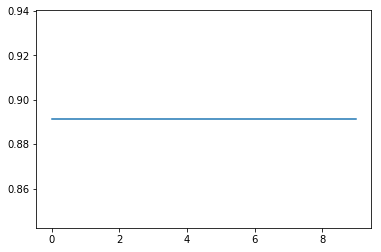

In [422]:
plt.plot(results_penalty)
plt.show()

In [373]:
max(results_penalty)

0.8913043478260869

**Pathwise E-Sig**

In [396]:
# specs for pathwise expected sig
sig_level1 = 4

# specs for signature
sig_level2 = 2

# pathwise expected sig  
X_feat_train = signature_features.scaled_pathwise_expected_iisignature([e.copy() for e in X_aug_train],sig_level1)
X_feat_train = iisignature.sig(X_feat_train,sig_level2)

X_feat_test = signature_features.scaled_pathwise_expected_iisignature([e.copy() for e in X_aug_test],sig_level1)
X_feat_test = iisignature.sig(X_feat_test,sig_level2)

# scaler = StandardScaler()
# to_fit = [X_feat_train[i] for i in range(len(X_feat_train))]
# scaler.fit(to_fit)
# X_feat_train = scaler.transform(X_feat_train)
# X_feat_test = scaler.transform(X_feat_test)

In [407]:
results_penalty = []
for p in np.linspace(1, 20, 10):
    clf = svm.SVC(kernel='linear',gamma=0.01,C=p,decision_function_shape='ovr')
    clf = clf.fit(X_feat_train,y_train)
    results_penalty.append(clf.score(X_feat_test, y_test))

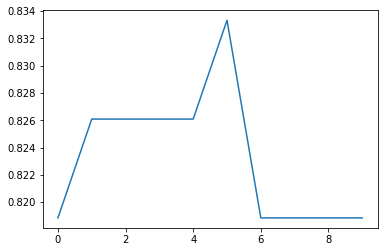

In [408]:
plt.plot(results_penalty)
plt.show()